# Example: DESHIMA 2.0 sensitivity calculation

## Introduction

This notebook shows an example of how to use the `desim` module to calculate the sensitivity of a DESHIMA-like spectrometer.
We will take the current goal specs of DESHIMA 2.0 as an example.

## Header

In [11]:
# IPython extension to reload modules before executing user code.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import pandas as pd

## Plotly 
import plotly as py
import plotly.graph_objs as go
import plotly.io as pio
import copy

## Matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15 ## font size
%matplotlib inline

# Load desim package
desim_path = '/Users/akira/desim'
import sys
sys.path.append(desim_path)
import desim as dsm # 

In [13]:
# Physical constants
h = 6.62607004 * 10**-34
k = 1.38064852 * 10**-23
e = 1.60217662 * 10**-19 # electron charge
c = 299792458.
Delta_Al = 188 * 10**-6 * e # gap energy of Al
eta_pb = 0.4

## Input beam size

In [14]:
# Approximate function based on the values of D2_2V3.pdf, p13
def D2HPBW(F):
    HPBW = 29.*240./(F/1e9) * np.pi / 180. / 60. / 60.
    return HPBW

## Input Ruze loss of the telescope 

In [15]:
# Ruze term of main beam efficiency
def eta_mb_ruze(F, LFlimit, sigma):
    '''F in Hz, LFlimit is the eta_mb at => 0 Hz, sigma in m'''
    eta_mb = LFlimit* np.exp(- (4.*np.pi* sigma * F/c)**2. )
    return eta_mb

eta_mb_ruze(np.asarray([350,492])*1e9,0.8,37e-6)

array([ 0.59582916,  0.44691052])

## Calculate the Minimum Detectable Line Flux

In [16]:
F = np.linspace(100,1000,9001)*1e9 # frequency range
# F = 3.5e11 # single frequency
HPBW = D2HPBW(F)
eta_mb = eta_mb_ruze(F=F,LFlimit=0.8,sigma=37e-6) * 0.9 # see specs, 0.9 is from EM, ruze is from ASTE

D2_in ={
    'F' : F,
    'pwv':0.5,
    'EL':60.,
    'R' : 500,
    'eta_M1_spill' : 0.99,
    'eta_M2_spill' : 0.90,
    'eta_wo' : 0.99,
    'eta_co' : 0.65, # product of co spillover, qo filter
    'eta_lens_antenna_rad' : 0.81, # D2_2V3.pdf, p14: front-to-back ratio 0.93 * reflection efficiency 0.9 * matching 0.98 * antenna spillover 0.993
    'eta_circuit' : 0.35, # 'Alejandro Efficiency', from the feedpoint of the antenna to being absorbed in the KID.
    'eta_IBF' : 0.6,
    'theta_maj' : HPBW,
    'theta_min' : HPBW,
    'eta_mb' : eta_mb,
    'Tb_cmb' : 2.725,
    'Tp_amb' : 273.,
    'Tp_cabin' : 290.,
    'Tp_co' : 4.,
    'Tp_chip' : 0.12,
    'snr' : 5,
    'obs_hours' :8.,
    'on_source_fraction':0.4
}

D2 = dsm.spectrometer_sensitivity(**D2_in)
ind = (D2['F']-350e9).abs().idxmin()
D2[ind:ind+1].transpose()

,2500
F,3.500000e+11
PWV,5.000000e-01
EL,6.000000e+01
eta_atm,9.015443e-01
R,5.000000e+02
W_F_spec,7.000000e+08
W_F_cont,1.166667e+09
theta_maj,9.640866e-05
theta_min,9.640866e-05
eta_a,4.756452e-01


In [25]:
F = np.linspace(100,1000,9001)*1e9 # frequency range
# F = 3.5e11 # single frequency
HPBW = D2HPBW(F)
eta_mb = eta_mb_ruze(F=F,LFlimit=0.8,sigma=37e-6) * 0.9 # see specs, 0.9 is from EM, ruze is from ASTE

D2_in ={
    'F' : F,
    'pwv':0.5,
    'EL':60.,
    'R' : 300,
    'eta_M1_spill' : 0.99,
    'eta_M2_spill' : 0.90,
    'eta_wo' : 0.,
    'eta_co' : 0.7*0.96, # product of co spillover, qo filter
    'eta_lens_antenna_rad' : 0.8, # D2_2V3.pdf, p14: front-to-back ratio 0.93 * reflection efficiency 0.9 * matching 0.98 * antenna spillover 0.993
    'eta_circuit' : 1, # 'Alejandro Efficiency', from the feedpoint of the antenna to being absorbed in the KID.
    'eta_IBF' : 1.,
    'theta_maj' : HPBW,
    'theta_min' : HPBW,
    'eta_mb' : eta_mb,
    'Tb_cmb' : 2.725,
    'Tp_amb' : 273.,
    'Tp_cabin' : 77.,
    'Tp_co' : 4.,
    'Tp_chip' : 0.12,
    'snr' : 5,
    'obs_hours' :8.,
    'on_source_fraction':0.4
}

D2 = dsm.spectrometer_sensitivity(**D2_in)
ind = (D2['F']-350e9).abs().idxmin()
D2[ind:ind+1].transpose()

/Users/akira/desim/desim.py:760: RuntimeWarning:

divide by zero encountered in true_divide



,2500
F,3.500000e+11
PWV,5.000000e-01
EL,6.000000e+01
eta_atm,9.016091e-01
R,3.000000e+02
W_F_spec,1.166667e+09
W_F_cont,1.166667e+09
theta_maj,9.640866e-05
theta_min,9.640866e-05
eta_a,4.756452e-01


### Export as CSV

In [23]:
0.67*0.96*0.8

0.51456

In [16]:
D2.to_csv(desim_path + '/examples/output/DESHIMA2_properties.csv',index=False)

## Plot Minimum Detectable Line Flux

### with Matplotlib

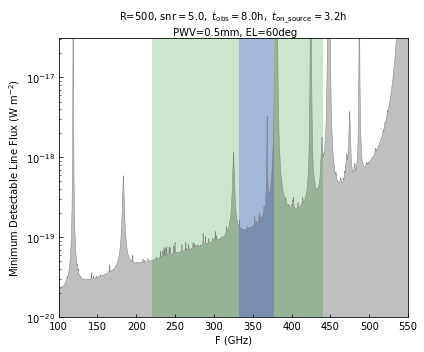

In [15]:
# Plot for printing

# Interactive plot
cropped = D2[(D2['MDLF'] < 1e-16) & (D2['MDLF'] > 1e-20)]  

fig, ax = plt.subplots(1,1,figsize=(6,5)) # facecolor='w'
ax.plot(cropped['F']/1e9,cropped['MDLF'],color='grey',linewidth=0.5)
ax.fill_between(cropped['F']/1e9,10**-21,cropped['MDLF'],
               facecolor='grey',alpha=0.5)
ax.fill_between([220,440],10**-21,[1e-15,1e-15],
               facecolor='green',alpha=0.2)
ax.fill_between([332,377],10**-21,[1e-15,1e-15],
               facecolor='blue',alpha=0.2)
ax.set_xlabel("F (GHz)")
ax.set_ylabel("Minimum Detectable Line Flux ($\mathrm{W\ m^{-2}}$)")
ax.set_yscale('log')
ax.set_xlim([100,550])
ax.set_ylim([10**-20,10**-16.5])
ax.tick_params(direction='in',which='both')
ax.set_title("R="+str(int(D2['R'][0]))+", snr$=" + str(D2['snr'][0]) + ',\ t_\mathrm{obs}=' 
             +str(D2_in['obs_hours'])+'\mathrm{h},\ t_\mathrm{on\_source}='
             +str(D2_in['obs_hours']*D2_in['on_source_fraction'])
             +'\mathrm{h}$\n PWV=' + str(D2['PWV'][0]) + "mm, EL="+str(int(D2['EL'][0]))+'deg',
             fontsize=10)
plt.tight_layout()
plt.savefig(desim_path + "/examples/output/MDLF_style.pdf",bbox_inches="tight")

### with plotly

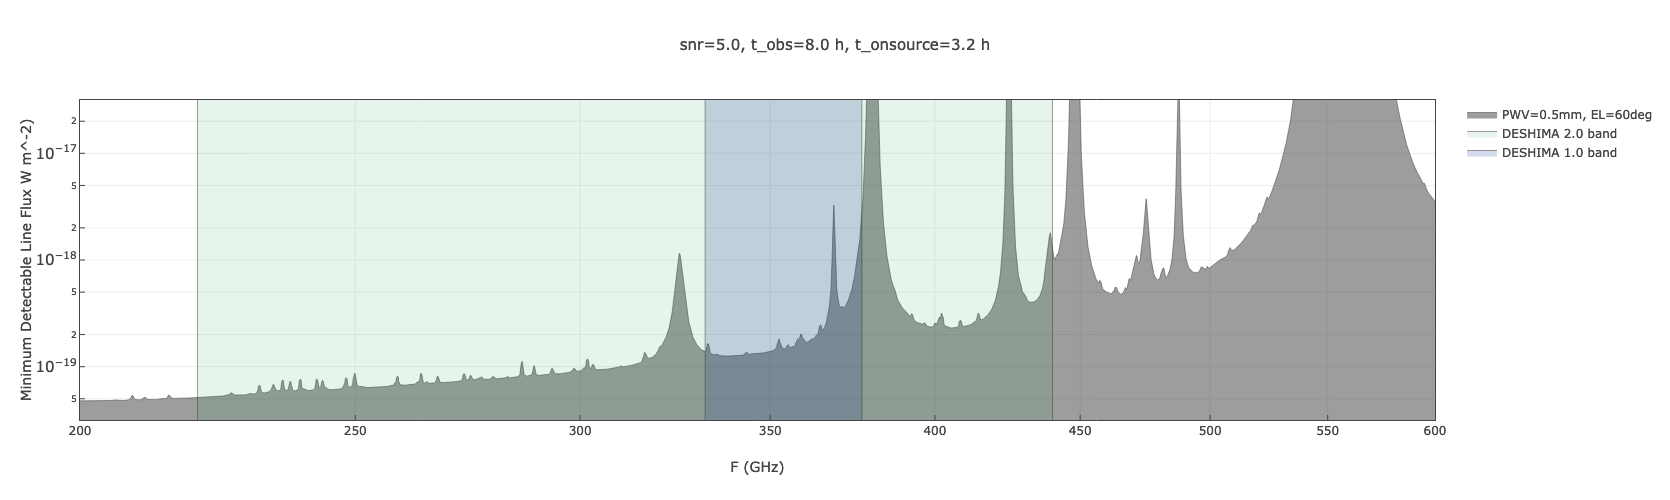

In [17]:
tr_MDLF = go.Scatter(
        x = cropped['F']/1e9,
        y = cropped['MDLF'],
        mode='lines',
        name="PWV="+str(D2['PWV'][0]) + "mm, EL="+str(int(D2['EL'][0]))+'deg',
        fill='tozeroy',
        line=dict(width=0.5,
              color='rgb(60, 60, 60)'),
    )

tr_D2band = go.Scatter(
        x = np.asarray([220,220,440,440]),
        y = np.asarray([1e-22,1e-15,1e-15,1e-22]),
        mode='lines',
        name="DESHIMA 2.0 band",
        fill='tozeroy',
        line=dict(width=0.5,
              color='rgb(60, 60, 60)'),
        fillcolor='rgba(26,150,65,0.1)'
    )

tr_D1band = go.Scatter(
        x = np.asarray([332,332,377,377]),
        y = np.asarray([1e-22,1e-15,1e-15,1e-22]),
        mode='lines',
        name="DESHIMA 1.0 band",
        fill='tozeroy',
        line=dict(width=0.5,
              color='rgb(60, 60, 60)'),
        fillcolor='rgba(26,65,150,0.2)'
    )

data = [tr_MDLF,tr_D2band,tr_D1band ]

layout = py.graph_objs.Layout(
    title= "snr=" + str(D2['snr'][0]) + ', t_obs=' + str(D2_in['obs_hours'])+' h, t_onsource='+str(D2_in['obs_hours']*D2_in['on_source_fraction'])+' h',
    titlefont = {"size": 15},
    xaxis=dict(
        title='F (GHz)',
        type='log',
        showgrid=True,
        range=np.log10([200, 600]),
        mirror=True,
        ticks='inside',
        showline=True
              ),
    yaxis=dict(title='Minimum Detectable Line Flux W m^-2)',
               type='log',
           showgrid=True,
#            range=[1e-21, 1e-19],
               range = [-19.5,-16.5],
           mirror=True,
           ticks='inside',
           showline=True
              ),
    width=600, height=500,
    showlegend=True
)

fig = py.graph_objs.Figure(data=data, layout=layout)

py.offline.iplot(fig)

# Export plot as files
pio.write_json(fig, desim_path + '/examples/output/MDLF.plotly')
pio.write_image(fig, desim_path + '/examples/output/MDLF.pdf')